In [1]:
import os
from pathlib import Path
from bifacial_radiance import *   
import numpy as np
import pandas as pd
import concurrent.futures
from subprocess import Popen, PIPE
import irrmapping


In [2]:
# set parameters
workfolder = os.getcwd()

if not os.path.exists(workfolder):
    os.makedirs(workfolder)
    
print ("Simulation will be stored in %s" % workfolder)

simulationname = 'Example1'


# Cell parameters

numcellsx = 10
numcellsy = 6
xcell = 0.166
ycell = 0.166
xcellgap = 0.002
ycellgap = 0.002
zcell = 0.0002              # thickness of the cell
glass = False
cellLevelModuleParams = {'numcellsx': numcellsx, 'numcellsy':numcellsy, 
                         'xcell': xcell, 'ycell': ycell, 'xcellgap': xcellgap, 'ycellgap': ycellgap}

# MakeModule Parameters
moduletype='test-module'
numpanels = 3 

xgap = 0.1 
ygap = 0.05 
zgap = 0 # no gap between modules and torquetube.

originx, originy, originz = (0, 0, 0) # Central coordinats for generated modules: applies to adapt module position with imported 3D objects

# TorqueTube Parameters
torquetube = False
axisofrotationTorqueTube = False

# SceneDict Parameters
pitch = 4   
albedo = 0.2   # ground albedo
hub_height = 4.3 + originz # m  
nMods = 7 
nRows = 3  

azimuth_ang = 190 # Facing southwest
tilt = 20 # tilt. 


demo = RadianceObj(simulationname,path = workfolder)
demo.setGround(albedo)
epwfile = demo.getEPW(40.0583,-74.4057) # NJ lat/lon 40.0583° N, 74.4057
metdata = demo.readWeatherFile(epwfile, coerce_year=2021) 

Simulation will be stored in C:\Users\Shuo Wang\Documents\RadianceWorkspace\radiance_work\example1
path = C:\Users\Shuo Wang\Documents\RadianceWorkspace\radiance_work\example1
Making path: images
Making path: objects
Making path: results
Making path: skies
Making path: EPWs
Making path: materials
Loading albedo, 1 value(s), 0.200 avg
1 nonzero albedo values.
Getting weather file: USA_NJ_McGuire.AFB.724096_TMY3.epw
 ... OK!
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos


In [3]:
#%% make scence

module = demo.makeModule(name=moduletype, numpanels=numpanels, xgap=xgap, ygap=ygap, cellModule=cellLevelModuleParams, glass=glass, z=zcell)

sceneDict = {'tilt':tilt, 'pitch': pitch, 'hub_height':hub_height, 'azimuth':azimuth_ang, 
             'nMods': nMods, 'nRows': nRows, 'originx':originx, 'originy':originy}  
scene = demo.makeScene(module=moduletype, sceneDict=sceneDict)


Module Name: test-module
Module was shifted by 0.083 in X to avoid sensors on air
This is a Cell-Level detailed module with Packaging Factor of 0.98 %
Module test-module updated in module.json


In [4]:
#%% create the cordinates for all the sensoring points
# here 3 columns of modules in the first row are sampled
mapdict = {'xcell':xcell, 'ycell':ycell, 'zcell':zcell,
           'xcellgap':xcellgap, 'ycellgap':ycellgap, 
           'numcellsx':numcellsx, 'numcellsy':numcellsy,
           'xgap':xgap, 'ygap':ygap, 'numpanels':numpanels,
           'nMods':nMods, 'nRows':nRows, 'originx':originx, 'originy':originy,
           'height':hub_height, 'pitch':pitch, 'tilt':tilt, 'azimuth':azimuth_ang}

lineptsFront, lineptsBack = irrmapping.genCors(**mapdict, modColRange=range(3))

In [5]:
#%% Generate Skyfile & Octfiles and run simulations. Results saved in .csv files
start_hour = '2021-06-17 10:0:0 -5'
end_hour = '2021-06-17 14:0:0 -5'
t_range = pd.date_range(start=start_hour, end=end_hour, freq='H')
irrmapping.concurMap(demo, lineptsFront, lineptsBack, t_range, accuracy='low')

Created Example1_2021-06-17_1400.oct
Created Example1_2021-06-17_1100.oct
Created Example1_2021-06-17_1200.oct
Created Example1_2021-06-17_1300.oct
Created Example1_2021-06-17_1000.oct
Full scan in process for: Example1_2021-06-17_1000_Front
Full scan in process for: Example1_2021-06-17_1100_Front
Full scan in process for: Example1_2021-06-17_1200_Front
Full scan in process for: Example1_2021-06-17_1300_Front
Full scan in process for: Example1_2021-06-17_1400_Front
Full scan in process for: Example1_2021-06-17_1300_Back
Full scan in process for: Example1_2021-06-17_1400_Back
Full scan in process for: Example1_2021-06-17_1100_Back
Full scan in process for: Example1_2021-06-17_1200_Back
Full scan in process for: Example1_2021-06-17_1000_Back


In [7]:
# #Options: check the positions of the sampling points
# create a marker object
name='MyMarker'
text='! genbox M_0010_Snow CenterMarker 0.03 0.03 0.1 | xform -t -0.015 -0.015 0'
customObject = demo.makeCustomObject(name,text)

lines = lineptsFront.split('\r')
for line in lines[:-1]:
    chars = line.split(' ')
    demo.appendtoScene(scene.radfiles, customObject, '!xform -t %s %s %s -rz 0'%(chars[0], chars[1], chars[2]))
scene.showScene()

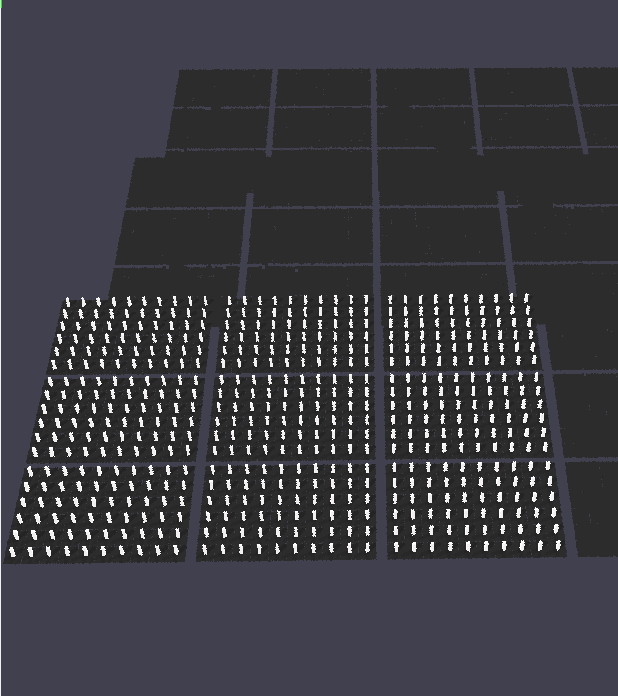

In [28]:
# #Options: test to control the sampling points with genCors function

module = demo.makeModule(name=moduletype, numpanels=numpanels, xgap=xgap, ygap=ygap, cellModule=cellLevelModuleParams, glass=glass, z=zcell)

sceneDict = {'tilt':tilt, 'pitch': pitch, 'hub_height':hub_height, 'azimuth':azimuth_ang, 
             'nMods': nMods, 'nRows': nRows, 'originx':originx, 'originy':originy}  
scene = demo.makeScene(module=moduletype, sceneDict=sceneDict)

lineptsFront, lineptsBack = irrmapping.genCors(**mapdict, modColRange=[0,2], modRowRange=[0,2], cellColRange=[0,2,4,6,8], cellRowRange=[0,2,4])


lines = lineptsFront.split('\r')
for line in lines[:-1]:
    chars = line.split(' ')
    demo.appendtoScene(scene.radfiles, customObject, '!xform -t %s %s %s -rz 0'%(chars[0], chars[1], chars[2]))
scene.showScene()



Module Name: test-module
Module was shifted by 0.083 in X to avoid sensors on air
This is a Cell-Level detailed module with Packaging Factor of 0.98 %
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten

Rendering scene. This may take a moment...


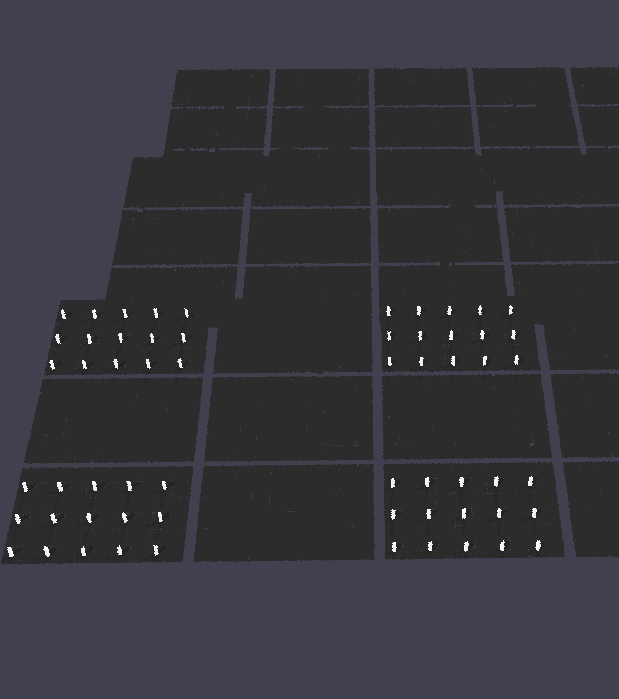

In [29]:
#Options: test to control the sampling points with genCors function

module = demo.makeModule(name=moduletype, numpanels=numpanels, xgap=xgap, ygap=ygap, cellModule=cellLevelModuleParams, glass=glass, z=zcell)

sceneDict = {'tilt':tilt, 'pitch': pitch, 'hub_height':hub_height, 'azimuth':azimuth_ang, 
             'nMods': nMods, 'nRows': nRows, 'originx':originx, 'originy':originy}  
scene = demo.makeScene(module=moduletype, sceneDict=sceneDict)

lineptsFront, lineptsBack = irrmapping.genCors(**mapdict, arrayRowRange=range(3), modColRange=[0], modRowRange=range(3), cellColRange=[0,2,4,6,8], cellRowRange=[0,2,4])

lines = lineptsFront.split('\r')
for line in lines[:-1]:
    chars = line.split(' ')
    demo.appendtoScene(scene.radfiles, customObject, '!xform -t %s %s %s -rz 0'%(chars[0], chars[1], chars[2]))

scene.showScene()



Module Name: test-module
Module was shifted by 0.083 in X to avoid sensors on air
This is a Cell-Level detailed module with Packaging Factor of 0.98 %
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten

Rendering scene. This may take a moment...


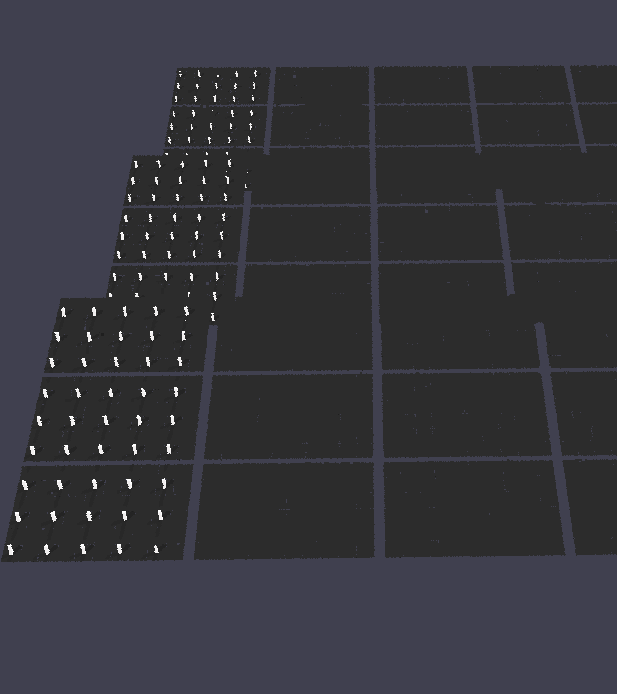